#  ICESat-2 L4 Monthly Gridded Sea Ice Thickness Dataset (IS2SITMOGR4)

**Summary** In this notebook, we provide a basic look at the Monthly Gridded Sea Ice Thickness Dataset (IS2SITMOGR4). We will show you how to easily download the data from our public google storage bucket and how to generate some simple plots for a few variables of interest. Our current focus is on this simpler, monthly gridded dataset. We hope in future efforts to showcase the hgiher-resolution along-track thickness dataset also: https://nsidc.org/data/is2sitdat4.

**Raw data link**: https://nsidc.org/data/is2sitmogr4/ (put in the data folder of this book to bypass the various access/download options we provide)
 

# Import notebook dependencies

In [1]:
import xarray as xr 
# Helper function for reading the data from the bucket
from utils.read_data_utils import read_IS2SITMOGR4 
#import s3fs

# Plotting dependencies
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from textwrap import wrap
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import time

# Helps avoid some weird issues with the polar projection 
GeoAxes._pcolormesh_patched = Axes.pcolormesh 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200 # Sets effective figure size in the notebook
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['xtick.labelsize']=9
mpl.rcParams['ytick.labelsize']=9
mpl.rcParams['legend.fontsize']=9
mpl.rcParams['font.size']=9

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

# Read in monthly gridded IS2SITMOGR4 thickness data
Here, we'll read in the data from the jupyter book using a function `read_IS2SITMOGR4` , defined in the `read_data_utils` module. You can also download this same data from the NSIDC. See the `data_wrangling` notebook for more information on this dataset.

We inclue two different ways of accessing the data:
 - 'zarr-s3': loads the complete IS2SITMOGR4 dataset that we have convenientely stored in the zarr format in an AWS S3 bucket. This is nice as it doesn't require any local download! The metadata is loaded into memory while the actual data can be persisted into memory at your choosing, or when you say plot the data. 
 - 'netcdf': in this case we first look to see if the data is available in the local data directory, if not we download the raw netcdf files form the S3 bucket, store them in the data directory then load them all into memory.

In this example, choosing persist=False provides a small time boost (10%), but we're only talking seconds on this machine. It's actually also quicker to read in the netcdf instead of zarr, but zarr benefits from not having to downloda actual data and is only a couple seconds longer. 

The dataset is stored in al cases as an xarray Dataset object. [xarray](http://xarray.pydata.org/en/stable/) is a python package built for working with gridded data and is particularly useful for climate data in the form of netcdf4 files. In the zarr case only the metadata is stored in memory until any computation/plotting is done. It's also chunked using Dask. 

In [2]:
# Read in as zarr and decide if we want to persist to memory or not 
# Largely depends how much subsetting etc you plan to do). 
# Data isn't big though so should not be a big deal to load into memory. 

start = time.time()

is2_ds = read_IS2SITMOGR4(data_type='netcdf', persist=False)

# Print docstring if you'd like
#print(read_IS2SITMOGR4.__doc__) 

/Users/aapetty/GitHub/akpetty/icesat2-book/content
local netcdf files available, use these
Load in netcdf files to xarray dataset
/Users/aapetty/GitHub/akpetty/icesat2-book/content/data/IS2SITMOGR4/V2/IS2SITMOGR4_01_201910_005_002.nc
/Users/aapetty/GitHub/akpetty/icesat2-book/content/data/IS2SITMOGR4/V2/IS2SITMOGR4_01_202111_005_002.nc
/Users/aapetty/GitHub/akpetty/icesat2-book/content/data/IS2SITMOGR4/V2/IS2SITMOGR4_01_201901_005_002.nc
/Users/aapetty/GitHub/akpetty/icesat2-book/content/data/IS2SITMOGR4/V2/IS2SITMOGR4_01_202011_005_002.nc
/Users/aapetty/GitHub/akpetty/icesat2-book/content/data/IS2SITMOGR4/V2/IS2SITMOGR4_01_201904_005_002.nc
/Users/aapetty/GitHub/akpetty/icesat2-book/content/data/IS2SITMOGR4/V2/IS2SITMOGR4_01_202203_005_002.nc
/Users/aapetty/GitHub/akpetty/icesat2-book/content/data/IS2SITMOGR4/V2/IS2SITMOGR4_01_201909_005_002.nc
/Users/aapetty/GitHub/akpetty/icesat2-book/content/data/IS2SITMOGR4/V2/IS2SITMOGR4_01_201912_005_002.nc
/Users/aapetty/GitHub/akpetty/icesat2-

# Overlay sea ice thickness on a map of the Arctic 
xarray allows us to generate a quick and simple map of the data in just a few lines of code. Below, we'll plot sea ice thickness for a single month. 

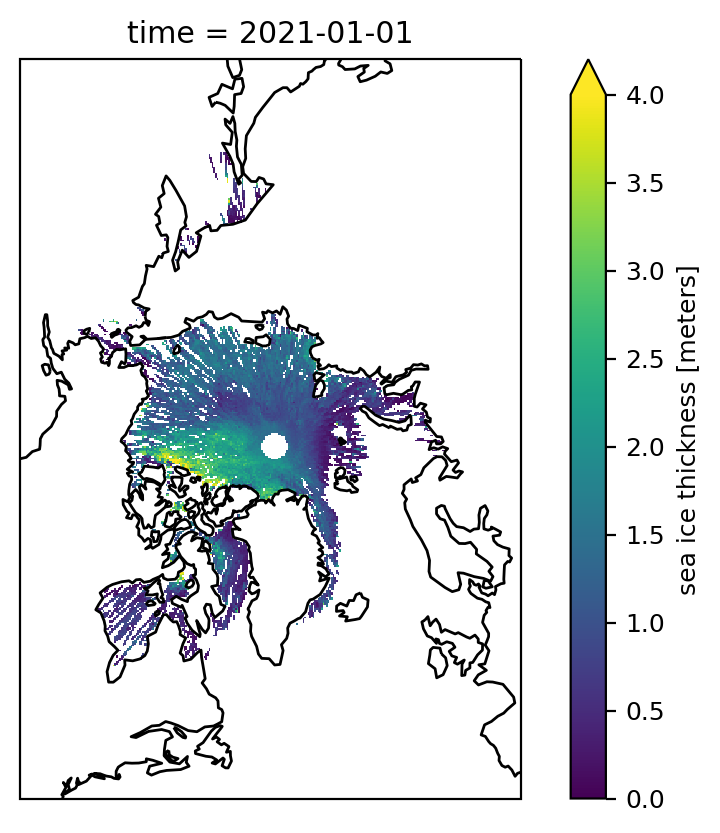

In [3]:
date = "Jan 2021"
var = "ice_thickness"
data_one_month = is2_ds[var].sel(time=date)
p = data_one_month.plot(x="longitude", y="latitude", # horizontal coordinates 
                        vmin=0, vmax=4, # min and max on the colorbar 
                        subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)}, # Set the projection 
                        transform=ccrs.PlateCarree())
p.axes.coastlines() # Add coastlines 
plt.show()

# Simple sea ice thickness maps
Using the function arguments `col` and `col_wrap`, we can modify the code for plotting one month of data to plot several months of data. Below, we'll plot sea ice thickness for Nov 2020 - Apr 2021.

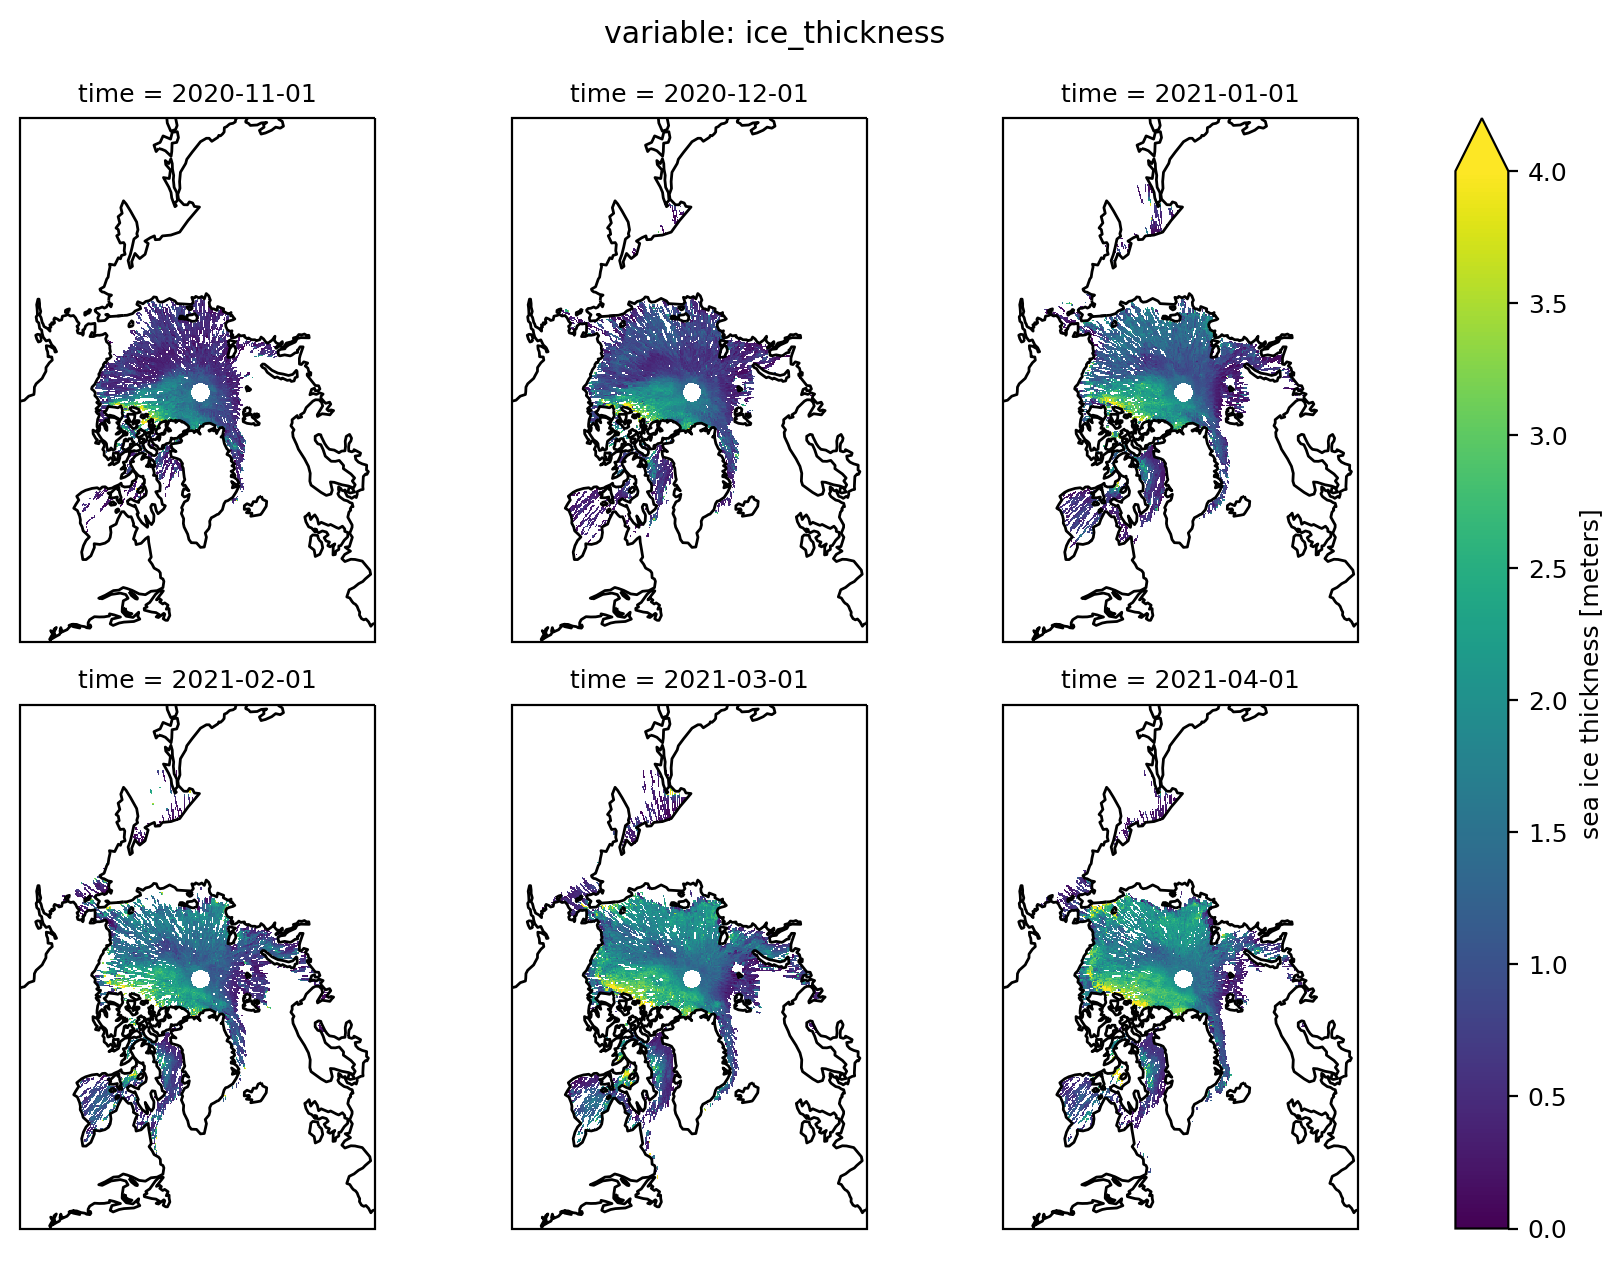

In [4]:
start_date = "Nov 2020"
end_date = "Apr 2021"
var = "ice_thickness" # Variable to use 
data_one_winter = is2_ds[var].sel(time=slice(start_date, end_date))
p = data_one_winter.plot(x="longitude", y="latitude", # Horizontal coordinates 
                         col="time", # Coordinate to use for facet grid 
                         col_wrap=3, # Number of columns to use 
                         vmin=0, vmax=4, # Min and max on the colorbar 
                         subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)}, # Set the projection 
                         transform=ccrs.PlateCarree())
for ax in p.axes.flat: # Add coastlines
    ax.coastlines()
plt.suptitle("variable: "+var, y=1.03) # Add a descriptive title
plt.show()

# Plot mean sea ice freeboard over time
Maybe we want to know how the mean has changed over time. Below, we'll compute the mean monthly sea ice freeboard for Sep 2020 - Apr 2021, and display the information in a simple lineplot. 

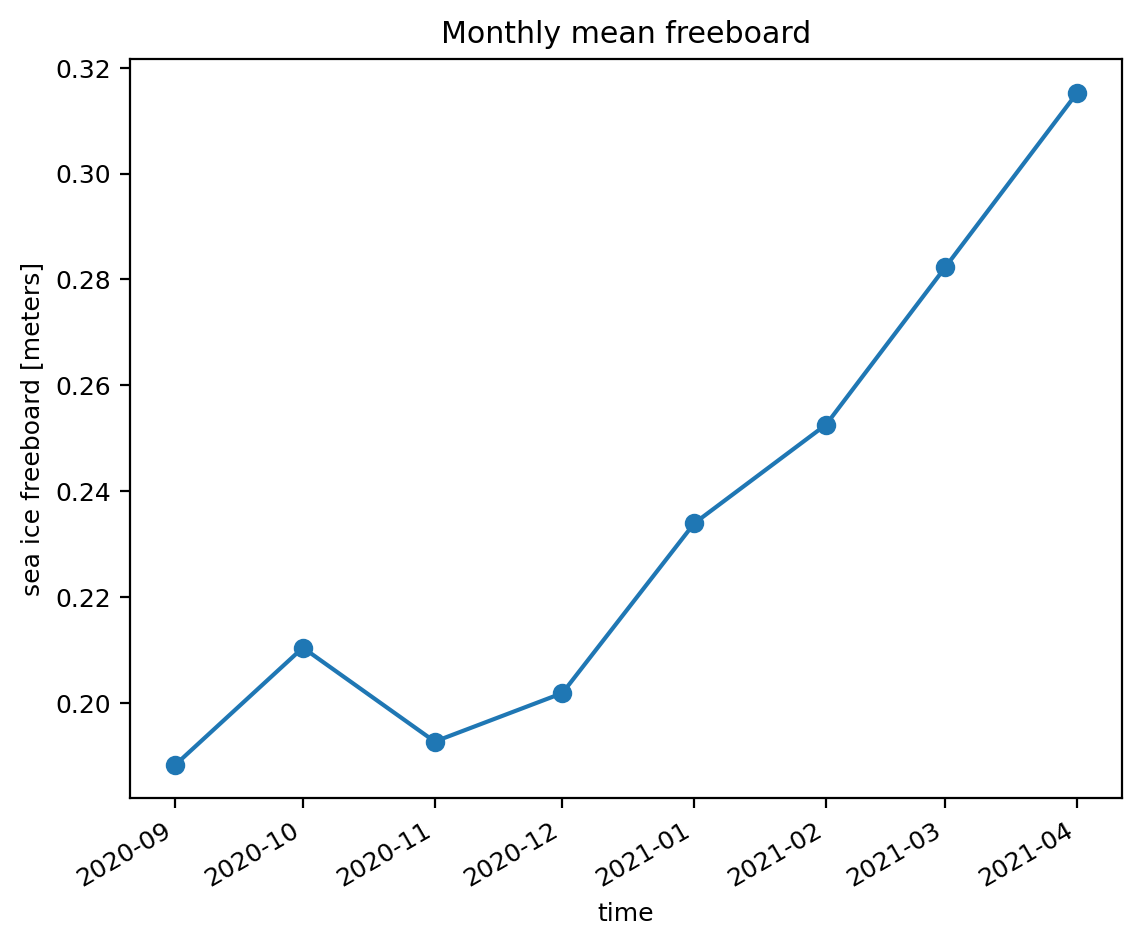

In [5]:
var = "freeboard" # Variable to use 
start_date = "Sep 2020"
end_date = "Apr 2021"
winter2020_21 = is2_ds.sel(time=slice(start_date, end_date)) # Grab data for Sep 2020 - Apr 2021
winter2020_21_mean = winter2020_21[var].mean(dim=["x","y"], # Dimensions over which to compute mean 
                                             keep_attrs=True) # Keep attributes from original dataset

lineplot = winter2020_21_mean.plot(marker='o') # Generate the lineplot 
plt.title("Monthly mean "+var) # Add a descriptive title 
plt.show()

## Restrict data to a given region
We use a region mask of the Arctic to allow us to select for regions of interest, and ignore other regions. This mask is included as a data variable in the ICESat-2 v2 data, and was provided courtesy W. Meier & S. Stewart, National Snow and Ice Data Center (NSIDC). 

In most of the analysis presented in this Jupyter Book, we restrict the data to the Inner Arctic domain, defined as the combined area of the Central Arctic, Beaufort Sea, Chukchi Sea, E Siberian Sea, Laptev Sea and Kara Sea. Freeboards and snow depths are generally more uncertain in the lower latitude peripheral seas of the Arctic.

![Arctic region mask](figs/region_mask.png "Inner Arctic region mask")

CA: Central Arctic, BS: Beaufort Sea, CS: Chukchi Sea, ESS: East Siberian Sea, LS: Laptev Sea, KS: Kara Sea, BaS: Barents Sea, EG: East Greenland Sea, GBB: Gulf of Bothnia, Baltic Sea, BB: Baffin Bay & Davis Strait, BeS: Bering Sea, SO: Sea of Okhotsk, GA: Gulf of Alaska. 


Here, we'll restrict the data to the Inner Arctic Ocean by selected the key values [1,2,3,4,5,6], corresponding to the six regions that compose the Inner Arctic Ocean. 


In [6]:
innerArctic = [1,2,3,4,5,6] #Inner Arctic Ocean
is2_ds_region_mask = is2_ds.copy()
is2_ds_region_mask = is2_ds_region_mask.where(is2_ds_region_mask.region_mask.isin(innerArctic))

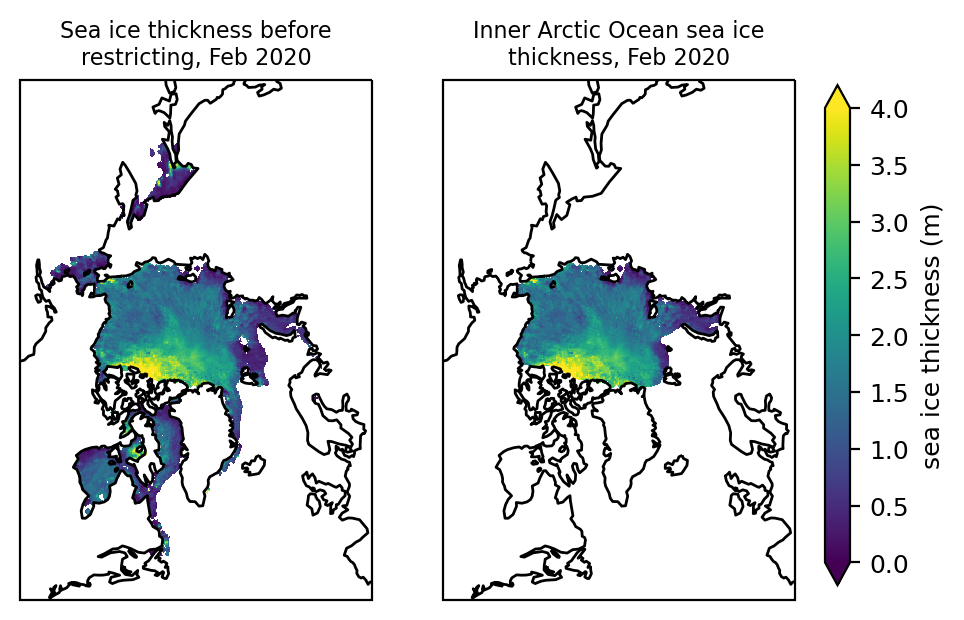

In [7]:
date = "Feb 2020"

fig, axes = plt.subplots(1, 2, figsize=(5,5), subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=-45)})
im1 = is2_ds["ice_thickness_int"].sel(time=date)[0].plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', vmin=0, vmax=4, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)
im2 = is2_ds_region_mask["ice_thickness_int"].sel(time=date)[0].plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', vmin=0, vmax=4, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)
plt.colorbar(im1, cax=fig.add_axes([0.93, 0.25, 0.025, 0.5]), extend='both', label="sea ice thickness (m)")

axes[0].set_title("\n".join(wrap("Sea ice thickness before restricting, "+date, 32)), fontsize=8)
axes[1].set_title("\n".join(wrap("Inner Arctic Ocean sea ice thickness, "+date, 32)), fontsize=8)
axes[0].coastlines()
axes[1].coastlines()

plt.show()

In [8]:
taken = time.time() - start
print(f"Time taken for notebook completion': {taken:0.2f} s")

Time taken for notebook completion': 18.53 s
